### Importing Libraries

In [1]:
import cv2
import numpy as np
import imageio as iio
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

### Reading Images

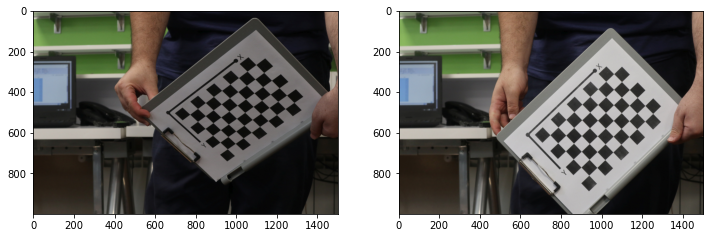

In [2]:
img1 = iio.imread("im01.jpg")
img2 = iio.imread("im02.jpg")
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img1);
plt.subplot(1,2,2)
plt.imshow(img2);

### Get edges using canny edge detector

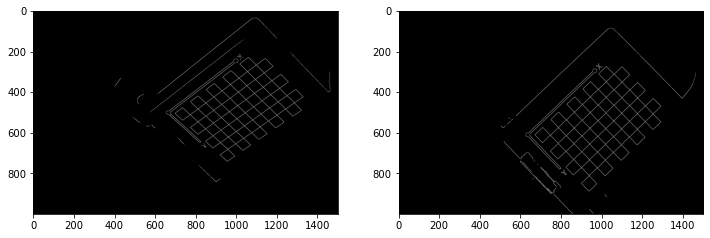

In [3]:
edges1 = cv2.Canny(image=img1, threshold1=380, threshold2=550) # Canny Edge 
edges2 = cv2.Canny(image=img2, threshold1=380, threshold2=550) # Canny Edge
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(edges1,cmap='gray');
plt.subplot(1,2,2)
plt.imshow(edges2,cmap='gray');
iio.imwrite("q1/res01.jpg",edges1)
iio.imwrite("q1/res02.jpg",edges2)
#print(edges1[400:410,1000:1010])

### Hough function 

<p> Hough function gets dtheta, drho as input and generates hough transform
    
set cosine puts the cosine in the hough matrix

In [4]:
def Hough(img,dt=2,dr=10):
    m,n = img.shape
    r_max = np.sqrt(m**2+n**2)
    out = np.zeros((2*int(r_max/dr),int(180/dt)))
    for i in range(m):
        for j in range(n):
            if img[i,j]:
                out = set_cosine(out,i,j,dt,dr)
    out = scale(out)
    return out.astype('uint8')

def set_cosine(img,x,y,dt=2,dr=10):
    m,n = img.shape
    out = img.copy()
    for j in range(n):
        theta = (j*dt-90)*np.pi/180
        rho = x*np.cos(theta)+y*np.sin(theta)
        out[int(rho/dr+m/2),j] += 1
    return out
def scale(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))*255

#### hough calculation

In [5]:
dr = 6
dt = 0.5
hough1 = Hough(edges1,dt=dt,dr=dr)
hough2 = Hough(edges2,dt=dt,dr=dr)

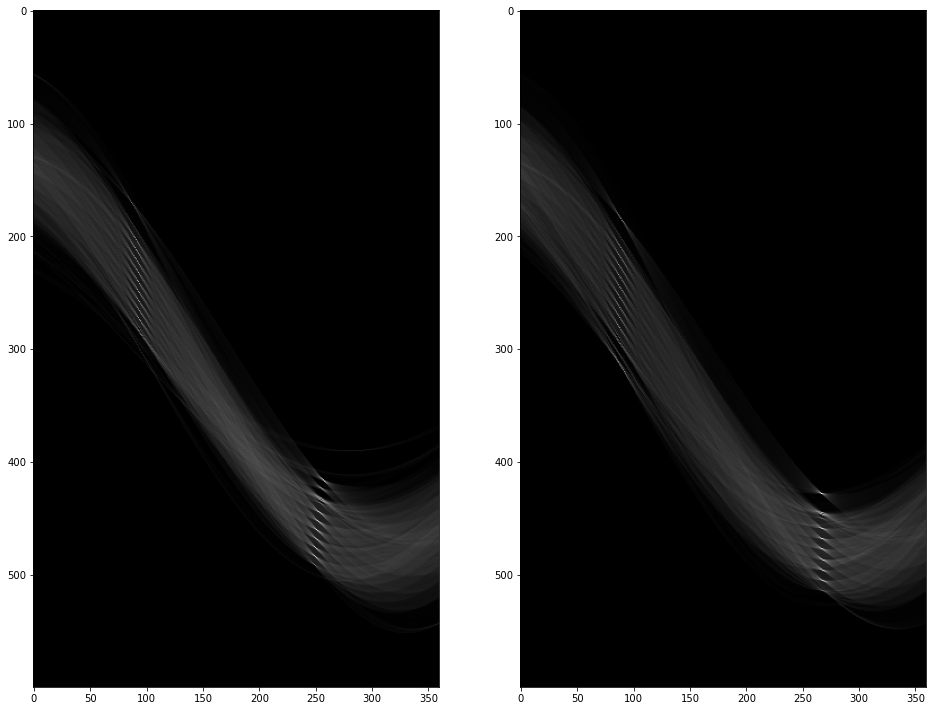

In [6]:
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(hough1,cmap='gray');
plt.subplot(1,2,2)
plt.imshow(hough2,cmap='gray');
iio.imwrite("q1/res03-hough-space.jpg",hough1)
iio.imwrite("q1/res04-hough-space.jpg",hough2)

<p> firts I puted a threshold for bright points,
    
then I used gaussian filter to connect points near each other then put another threshold to get one point,
    
after all I used a filter to clear unwanted pixels with more than 3 neighbors 

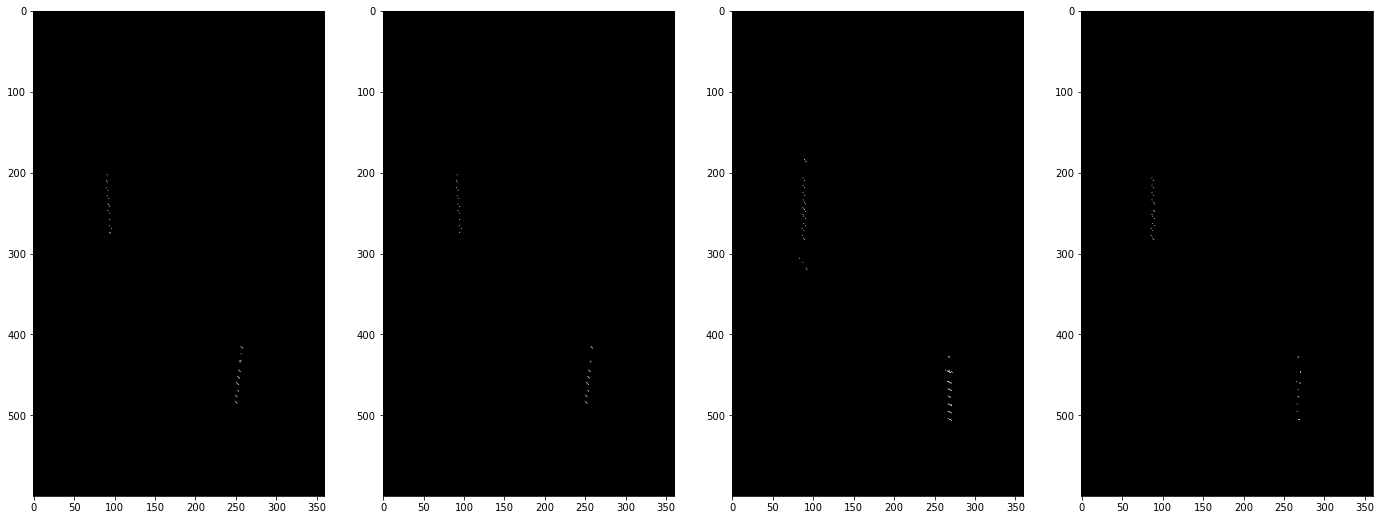

In [7]:
threshold1 = 140+20
threshold2 = 130+0
points1 = hough1>threshold1
points2 = hough2>threshold2
pg1 = gaussian_filter(255*points1, sigma=0.9)
pg2 = gaussian_filter(255*points2, sigma=0.9)
#pg2 = pg2>50

for i in range(pg1.shape[0]):
        for j in range(pg1.shape[1]):
            if pg1[i,j] >= 50 and i < 300:
                pg1[i,j] = 255
            elif pg1[i,j] >= 64 and i > 300:
                pg1[i,j] = 255
            else:
                pg1[i,j] = 0
                
for i in range(pg2.shape[0]):
        for j in range(pg2.shape[1]):
            if pg2[i,j] >= 42 and i < 300:
                pg2[i,j] = 255
            elif pg2[i,j] >= 77 and i > 300:
                pg2[i,j] = 255
            else:
                pg2[i,j] = 0

def filt(img):
    img = img.copy()
    for i in range(10, img.shape[0]-10):
        for j in range(10, img.shape[1]-10):
            one = 0
            if img[i+1,j] == 255:
                one += 1
            if img[i-1,j] == 255:
                one += 1
            if img[i,j+1] == 255:
                one += 1
            if img[i,j-1] == 255:
                one += 1
            if img[i+1,j+1] == 255:
                one += 1
            if img[i+1,j-1] == 255:
                one += 1
            if img[i-1,j+1] == 255:
                one += 1
            if img[i-1,j-1] == 255:
                one += 1
            if one >= 3:
                img[i+1,j] = 0
                img[i-1,j] = 0
                img[i,j+1] = 0
                img[i,j-1] = 0
                img[i+1,j+1] = 0
                img[i+1,j-1] = 0
                img[i-1,j+1] = 0
                img[i-1,j-1] = 0
    return img

pg1 = filt(pg1)
pg11 = gaussian_filter(255*pg1, sigma=0.9)
for i in range(pg11.shape[0]):
        for j in range(pg1.shape[1]):
            if pg11[i,j] >= 70 and i < 300:
                pg11[i,j] = 255
            elif pg11[i,j] >= 64 and i > 300:
                pg11[i,j] = 255
            else:
                pg11[i,j] = 0
pg11 = filt(pg11)

pg2 = filt(pg2)

plt.figure(figsize=(24,16))
plt.subplot(1,4,1)
plt.imshow(points1,cmap='gray');
plt.subplot(1,4,2)
plt.imshow(pg1,cmap='gray');

plt.subplot(1,4,3)
plt.imshow(points2,cmap='gray');
plt.subplot(1,4,4)
plt.imshow(pg2,cmap='gray');

<p> Drawing lines from points of last part(pg1, pg11, pg2),
    
and I calculated useful data such as array of rhos, thetas, nearby rhos(to generate drho of chess), ...
    
all lines are in all_lines images, selected lines are stored in lines and drow in imgs it self

In [36]:
img1 = iio.imread("im01.jpg")
img2 = iio.imread("im02.jpg")
m,n = pg1.shape
all_lines1 = img1.copy()
lines1 = np.zeros((img1.shape[0],img1.shape[1]))
all_lines2 = img2.copy()
lines2 = np.zeros((img2.shape[0],img2.shape[1]))
drho=0
rhos = []
r1 = [] #rhos1
t1 = [] #theta1s
r2 = [] #rhos2
t2 = [] #theta2s

for i in range(m):
    for j in range(n):
        if pg1[i,j] :
            rho = (i-m/2)*dr
            theta = (j-n/2)*dt*np.pi/180
            #print(rho, theta)
            if rho>0 :
                x1 = 200
                x2 = 800
                cv2.line(all_lines1,(y1,x1),(y2,x2),(200,0,0),3)
            else :
                x1 = 200 + int((580-abs(int(rho)))//1.8)
                x2 = 800 - int(abs(int(rho))//2)
                y1 = int((rho-x1*np.cos(theta))/np.sin(theta))
                y2 = int((rho-x2*np.cos(theta))/np.sin(theta))
                cv2.line(img1,(y1,x1),(y2,x2),(200,0,0),3) #drawing lines
                cv2.line(lines1,(y1,x1),(y2,x2),(200,0,0),3)
                cv2.line(all_lines1,(y1,x1),(y2,x2),(200,0,0),3)
                r1.append(rho)
                t1.append(theta)
                #print(rho,theta)
        if pg11[i,j] :
            rho = (i-m/2)*dr
            theta = (j-n/2)*dt*np.pi/180
            #print(rho, theta)
            if rho>0 :
                x1 = 200
                x2 = 800
                y1 = int((rho-x1*np.cos(theta))/np.sin(theta))
                y2 = int((rho-x2*np.cos(theta))/np.sin(theta))
                cv2.line(all_lines1,(y1,x1),(y2,x2),(200,0,0),3)
                if not (rho<830 and theta>0):
                    #print(rho)
                    cv2.line(img1,(y1,x1),(y2,x2),(200,0,0),3) #drawing lines
                    cv2.line(lines1,(y1,x1),(y2,x2),(200,0,0),3)
                    r1.append(rho)
                    t1.append(theta)
            else :
                x1 = 200
                x2 = 800
                cv2.line(all_lines1,(y1,x1),(y2,x2),(200,0,0),3)
        if pg2[i,j] :
            rho = (i-m/2)*dr
            theta = (j-n/2)*dt*np.pi/180
            if rho>0 :
                x1 = 200
                x2 = 900
            else :
                #print(rho)
                x1 = 200 + int((580-abs(int(rho)))//1.5)
                x2 = 900 - int(abs(int(rho))//2)
            y1 = int((rho-x1*np.cos(theta))/np.sin(theta))
            y2 = int((rho-x2*np.cos(theta))/np.sin(theta))
            cv2.line(all_lines2,(y1,x1),(y2,x2),(200,0,0),3)
            if not(rho<950 and theta>0):
                if rho>0:
                    if(rho>1000 and rho<1200 and rho not in rhos):
                        rhos.append(rho)
                cv2.line(img2,(y1,x1),(y2,x2),(200,0,0),3) #drawing lines
                cv2.line(lines2,(y1,x1),(y2,x2),(200,0,0),3)
                r2.append(rho)
                t2.append(theta)
drho = (max(rhos)-min(rhos))/(len(rhos)-1)
e=int(drho/3.5)
print("delta rho =",drho)


delta rho = 54.0


<p> for corner calculation I worte a function that gives a common point of two lines whith polar parameters,
    
I calculated 4 outer lines and added the last imaginerly line by drho and generated corner points with error(which was corrected by a factor of drho to be closer to lines)

In [37]:
def getxy(p1,t1,p2,t2):
    x = (p2-p1*np.sin(t2)/np.sin(t1))/(np.cos(t2)-np.cos(t1)*np.sin(t2)/np.sin(t1))
    y = (p1-x*np.cos(t1))/np.sin(t1)
    return int(x),int(y)

print("image 1 four lines rho, thetas:")
r1p_min = max(r1)
r1p_max = max(r1) # ok
r1n_min = min(r1) # ok
r1n_max = min(r1)
for i in range(len(r1)):
    if r1[i]<0 and r1[i]>r1n_max:
        r1n_max = r1[i]
    if r1[i]>0 and r1[i]<r1p_min:
        r1p_min = r1[i]
print(r1p_min,r1p_max)
print(r1n_min,r1n_max)
t1_pos = 0
n1_pos = 0
t1_neg = 0
n1_neg = 0
for i in range(len(t1)):
    if t1[i]>0:
        t1_pos+=t1[i]
        n1_pos+=1
    if t1[i]<0:
        t1_neg+=t1[i]
        n1_neg+=1
t1_pos = t1_pos/n1_pos
t1_neg = t1_neg/n1_neg
print(t1_pos,t1_neg)
#x,y 4 corners
x11,y11 = getxy(r1p_min-drho,t1_pos,r1n_max+drho,t1_neg)
x12,y12 = getxy(r1p_min-drho,t1_pos,r1n_min-drho,t1_neg)
x13,y13 = getxy(r1p_max+drho,t1_pos,r1n_max+drho,t1_neg)
x14,y14 = getxy(r1p_max+drho,t1_pos,r1n_min-drho,t1_neg)
x11 -= e
y11 += e
y12 -= e
x13 -= e
y13 += e
x14 += e
y14 -= e
print("image 2 four lines rho, thetas:")
r2p_min = max(r2)
r2p_max = max(r2) # ok
r2n_min = min(r2) # ok
r2n_max = min(r2)
for i in range(len(r2)):
    if r2[i]<0 and r2[i]>r2n_max:
        r2n_max = r2[i]
    if r2[i]>0 and r2[i]<r2p_min:
        r2p_min = r2[i]
print(r2p_min,r2p_max)
print(r2n_min,r2n_max)
t2_pos = 0
n2_pos = 0
t2_neg = 0
n2_neg = 0
for i in range(len(t2)):
    if t2[i]>0:
        t2_pos+=t2[i]
        n2_pos+=1
    if t2[i]<0:
        t2_neg+=t2[i]
        n2_neg+=1
t2_pos = t2_pos/n2_pos
t2_neg = t2_neg/n2_neg
print(t2_pos,t2_neg)
#x,y 4 corners
x21,y21 = getxy(r2p_min-drho,t2_pos,r2n_max+drho,t2_neg)
x22,y22 = getxy(r2p_min-drho,t2_pos,r2n_min-drho,t2_neg)
x23,y23 = getxy(r2p_max+drho,t2_pos,r2n_max+drho,t2_neg)
x24,y24 = getxy(r2p_max+drho,t2_pos,r2n_min-drho,t2_neg)
x22 += e
y22 -= e
y24 -= e

image 1 four lines rho, thetas:
888.0 1122.0
-582.0 -156.0
0.6505318121069774 -0.7632906595388534
image 2 four lines rho, thetas:
960.0 1230.0
-558.0 -102.0
0.7660056161530667 -0.8007736829983505


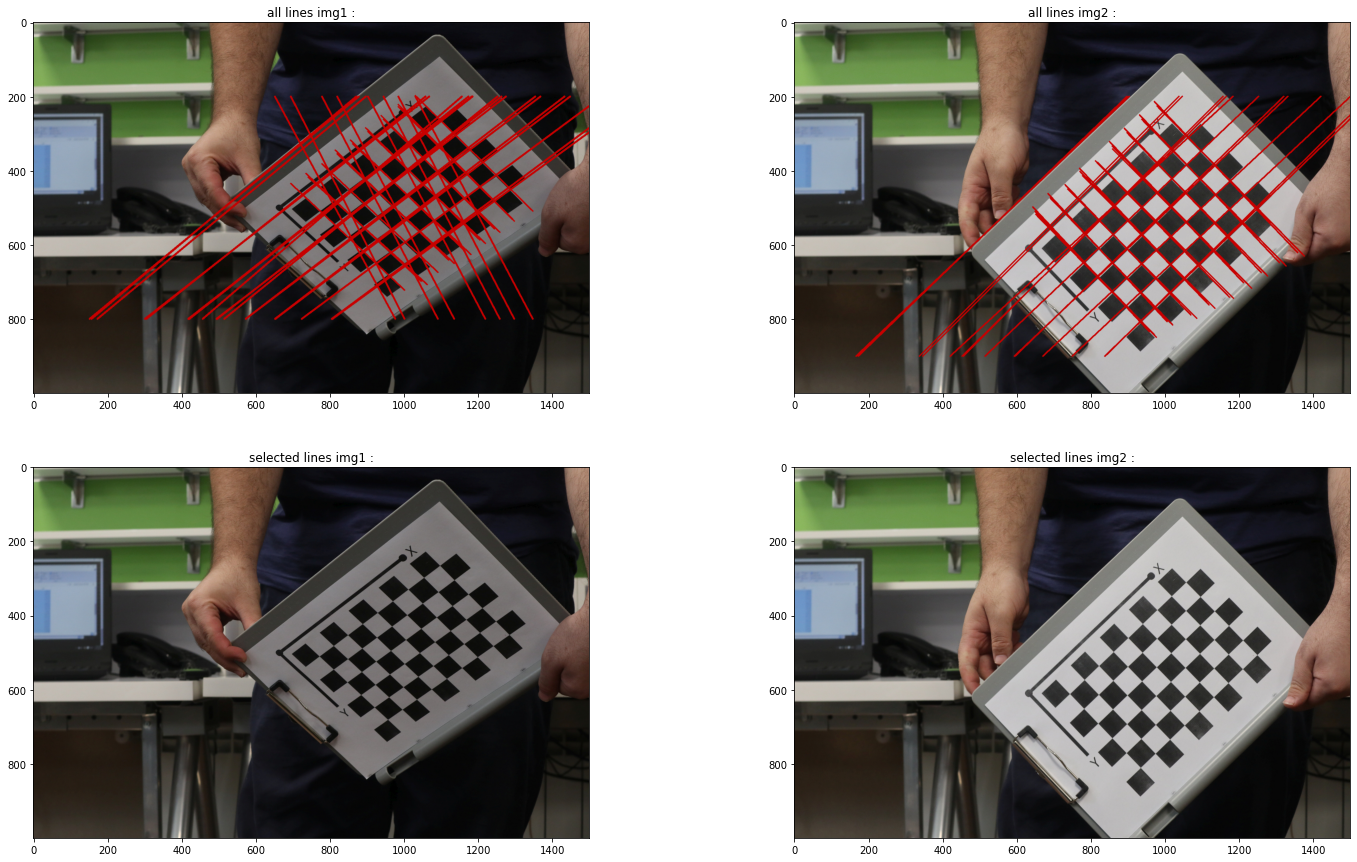

In [48]:
plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
plt.imshow(all_lines1,cmap='gray');
plt.title('all lines img1 :')
plt.subplot(2,2,2)
plt.imshow(all_lines2,cmap='gray');
plt.title('all lines img2 :')
iio.imwrite("q1/res05-lines.jpg",all_lines1)
iio.imwrite("q1/res06-lines.jpg",all_lines2)

plt.subplot(2,2,3)
plt.imshow(img1);
plt.title('selected lines img1 :')
plt.subplot(2,2,4)
plt.imshow(img2);
plt.title('selected lines img2 :');
iio.imwrite("q1/res07-chess.jpg",img1)
iio.imwrite("q1/res08-chess.jpg",img2)

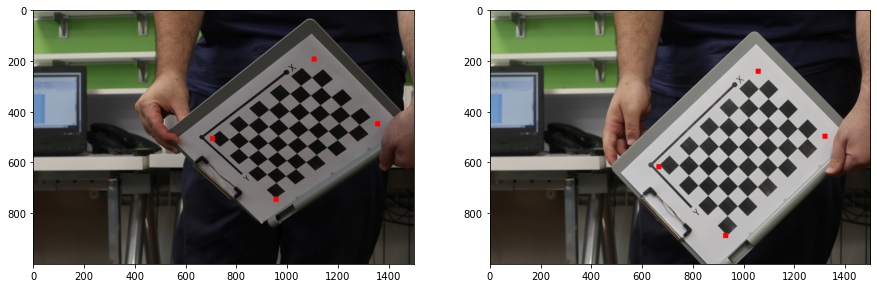

In [46]:
img1 = iio.imread("im01.jpg")
img2 = iio.imread("im02.jpg")

corners1 = img1.copy()
corners2 = img2.copy()

dd = 10
corners1[x11-dd:x11+dd,y11-dd:y11+dd] = 0
corners1[x11-dd:x11+dd,y11-dd:y11+dd,0] = 255
corners1[x12-dd:x12+dd,y12-dd:y12+dd] = 0
corners1[x12-dd:x12+dd,y12-dd:y12+dd,0] = 255
corners1[x13-dd:x13+dd,y13-dd:y13+dd] = 0
corners1[x13-dd:x13+dd,y13-dd:y13+dd,0] = 255
corners1[x14-dd:x14+dd,y14-dd:y14+dd] = 0
corners1[x14-dd:x14+dd,y14-dd:y14+dd,0] = 255

corners2[x21-dd:x21+dd,y21-dd:y21+dd] = 0
corners2[x21-dd:x21+dd,y21-dd:y21+dd,0] = 255
corners2[x22-dd:x22+dd,y22-dd:y22+dd] = 0
corners2[x22-dd:x22+dd,y22-dd:y22+dd,0] = 255
corners2[x23-dd:x23+dd,y23-dd:y23+dd] = 0
corners2[x23-dd:x23+dd,y23-dd:y23+dd,0] = 255
corners2[x24-dd:x24+dd,y24-dd:y24+dd] = 0
corners2[x24-dd:x24+dd,y24-dd:y24+dd,0] = 255

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(corners1);
plt.subplot(1,2,2)
plt.imshow(corners2);

iio.imwrite("q1/res09-corners.jpg",corners1)
iio.imwrite("q1/res10-corners.jpg",corners2)

<p> apart form mathemathical calculation I tried to get points by image processing which didn't work that well and end up without a computational solution, but some visual improvements happened.

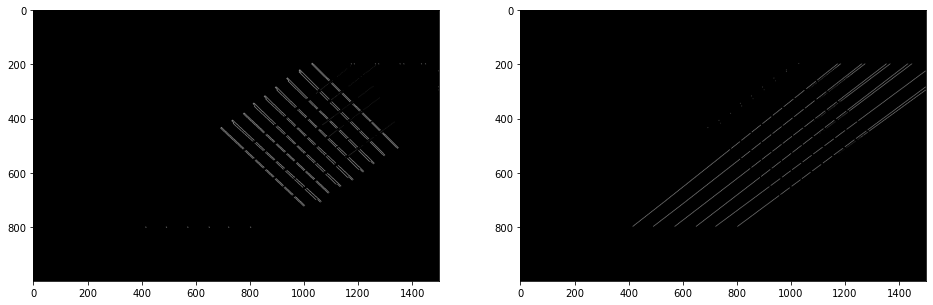

In [45]:
gaus1 = cv2.Sobel(lines1, cv2.CV_8U, 1, 0, 0) ^ cv2.Sobel(lines1, cv2.CV_8U, 0, 1, 0)
gaus2 = cv2.Sobel(lines1, cv2.CV_8U, 1, 0, 0) & cv2.Sobel(lines1, cv2.CV_8U, 0, 1, 0)
gaus1 = 128*(gaus1==255).astype('uint8')
gaus2 = 128*(gaus2==255).astype('uint8')
#gaus1 = (gaus1^gaus2)
'''
gaus1 = gaus1 & gaus2
gaus1 = gaus1*lines1
gaus2 = lines1
'''
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(gaus1,cmap='gray');
plt.subplot(1,2,2)
plt.imshow(gaus2,cmap='gray');
#print(np.array(np.where(gaus1==np.max(gaus1))).flatten())